In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np 
from torchvision.datasets import MNIST
from scipy.spatial.distance import cdist
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the data to a tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the data to have mean 0.1307 and standard deviation 0.3081
])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='../data/Mnist_data/', train=True, download=True, transform=transform)
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='../data/Mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:03<00:00, 3228606.20it/s]


Extracting ../data/Mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ../data/Mnist_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3959329.75it/s]


Extracting ../data/Mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ../data/Mnist_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2676358.13it/s]


Extracting ../data/Mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/Mnist_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ../data/Mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/Mnist_data/MNIST\raw



In [3]:
# Filter out images and labels corresponding to digits other than 0, 1, 2, and 3
indices = np.isin(train_dataset.targets, [0, 1, 2, 3])
images = train_dataset.data[indices]
labels = train_dataset.targets[indices]

# Create a new dataset with the filtered images and labels
train_dataset_filtered = torch.utils.data.TensorDataset(images.unsqueeze(1).float()/255, labels)

# Create a data loader for the new dataset
train_loader_filtered = torch.utils.data.DataLoader(train_dataset_filtered, batch_size=128, shuffle=True)

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder layers  
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256), # 32 
            nn.ReLU(),
            nn.Linear(256, 128), # 16
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2) # 8 
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [6]:
# Define the VAE model
model = VAE()

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training parameters
learning_rate = 1e-3 # -2 
num_epochs = 50
batch_size = 128


# Define the training function
def train(model, train_loader, learning_rate, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function: reconstruction loss + KL divergence loss
    def loss_function(x_hat, x, z_mean, z_logvar):
        bce_loss = nn.functional.mse_loss(x_hat, x.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + (kld_loss * 0.01) #  (0.01  *kld_loss)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, z_mean, z_logvar = model(x)
            loss = loss_function(x_hat, x, z_mean, z_logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader.dataset)
        print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

        # Generate and save a sample image every 5 epochs
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                z = torch.randn(64, model.latent_dim).to(device)
                sample = model.decode(z).view(64, 1, 28, 28)
                save_image(sample, 'vae_samples_epoch{}.png'.format(epoch+1))

In [9]:

# Check if CUDA is available
if torch.cuda.is_available():
    # If CUDA is available, set the device to GPU
    device = torch.device("cuda")
    # Move the model to the GPU
    model.to(device)
    print("Model is now running on GPU (CUDA)")
else:
    print("CUDA is not available. Model remains on CPU.")

CUDA is not available. Model remains on CPU.


In [10]:
# Train the VAE model using the train function
train(model, train_loader_filtered, learning_rate, 5, device)

Epoch [1/5], Average Loss: 22.2645
Epoch [2/5], Average Loss: 22.1430
Epoch [3/5], Average Loss: 22.1838
Epoch [4/5], Average Loss: 22.1446
Epoch [5/5], Average Loss: 22.0499


In [12]:
torch.save(VAE.state_dict(model), './Model_state/VAE_Mnist.pth')

In [14]:
VAE.load_state_dict(model, torch.load('./Model_state/VAE_Mnist.pth'))

<All keys matched successfully>

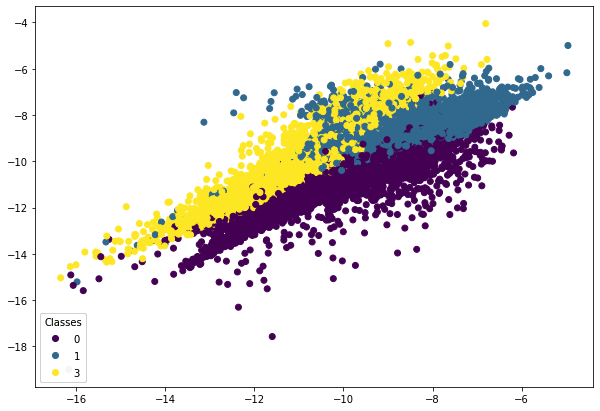

In [15]:
# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 1)|(mnist_train.targets == 3))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()

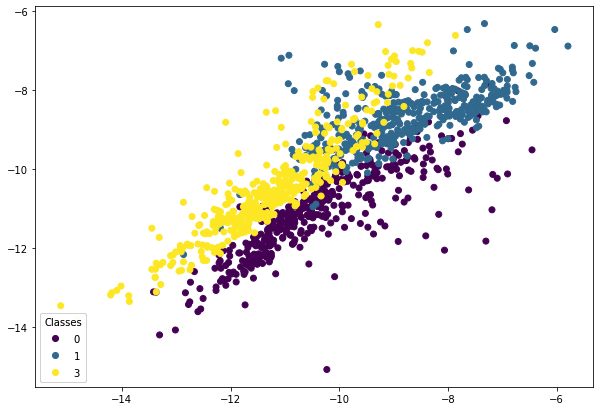

In [16]:
import random

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 1)|(mnist_train.targets == 3))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Select 500 samples from each class randomly
samples_per_class = 400
class_indices = []
for i in [0,  1,3]:
    class_i_indices = torch.where(mnist_subset_targets == i)[0]
    selected_indices = random.sample(class_i_indices.tolist(), samples_per_class)
    class_indices += selected_indices

# Use the selected indices to get the subset
mnist_subset = mnist_subset[class_indices]
mnist_subset_targets = mnist_subset_targets[class_indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()

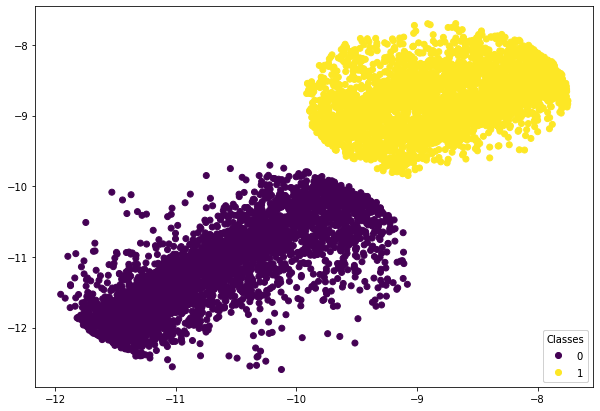

In [22]:
# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 1))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 16
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Compute the mean of the latent vectors for each class
means = []
for i in [0,1,3]:
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    mean = class_vectors.mean(dim=0)
    means.append(mean)

# Select x samples from each class that are close to the mean, but not too close
num_samples = 3500
sample_indices = []
for i, mean in zip([0,1,3], means):
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    distances = np.linalg.norm(class_vectors - mean.cpu().numpy(), axis=1)
    sorted_indices = np.argsort(distances)
    closest_indices = sorted_indices[:num_samples//2]
    farthest_indices = sorted_indices[num_samples//2:num_samples]
    sample_indices.extend(class_indices[closest_indices].tolist())
    sample_indices.extend(class_indices[farthest_indices].tolist())

# Select the samples from the subset and their corresponding targets
mnist_subset = mnist_subset[sample_indices]
mnist_subset_targets = mnist_subset_targets[sample_indices]

# Pass the subset to a DataLoader
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
ax.add_artist(legend)
plt.show()

Nearest neighbor: tensor([[-9.3298, -9.7521]])
Nearest neighbor label: tensor([1])


<ipython-input-23-6cd6f2fc856f>:51: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, Z.reshape(xx.shape), alpha=0.5, linewidths=5)


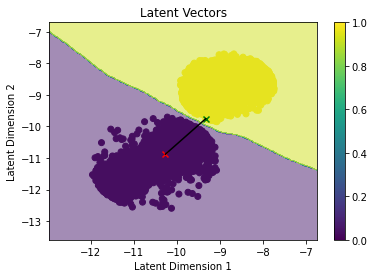

In [23]:
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
# separate the dataset by class
class_0 = torch.where(mnist_subset_targets == 0)[0]
# Create a mask to filter out samples that are not in class 1
mask = (mnist_subset_targets != 0).squeeze()

# Select samples from latent space that are not in class 1
latent_space_not_0 = latent_vectors[mask]
latent_space_not_0 = latent_space_not_0[:,:2]

#random point from class0 
random_index = torch.randint(high=class_0.shape[0], size=(1,))  # Choose a random index
class_0_random = latent_vectors[random_index]
class_0_random= class_0_random[:,:2]


# Find the nearest neighbor of the point in class 0 among the other classes
nn = NearestNeighbors(n_neighbors=1)
nn.fit(latent_space_not_0)

distances, indices = nn.kneighbors(class_0_random)

nearest_neighbor = latent_space_not_0[indices[0]]
nearest_neighbor_label =  mnist_subset_targets[mask][indices[0]]

print("Nearest neighbor:", nearest_neighbor)
print("Nearest neighbor label:", nearest_neighbor_label)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(latent_vectors, mnist_subset_targets)

# Define a grid of points in the latent space
x_min, x_max = latent_vectors[:, 0].min() - 1, latent_vectors[:, 0].max() + 1
y_min, y_max = latent_vectors[:, 1].min() - 1, latent_vectors[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 250), torch.linspace(y_min, y_max, 250))
grid_latent_vectors = torch.stack([xx.ravel(), yy.ravel()], axis=1)

# Make predictions with the classifier for the grid of points
Z = knn.predict(grid_latent_vectors)
#lab = knn.predict(mnist_subset_targets)

# Plot the full latent vectors in 2 dimensions
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=mnist_subset_targets)
plt.colorbar()
plt.title('Latent Vectors')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Plot the random point from class 0
plt.contourf(xx, yy, Z.reshape(xx.shape), alpha=0.5, linewidths=5)
plt.scatter(class_0_random[0,0], class_0_random[0,1], c='r', marker='x')

# Plot the nearest neighbor from the other classes
plt.scatter(nearest_neighbor[0,0], nearest_neighbor[0,1], c='g', marker='x')

# Draw a line between the random point and its nearest neighbor
plt.plot([class_0_random[0,0], nearest_neighbor[0,0]], [class_0_random[0,1], nearest_neighbor[0,1]], c='k')

plt.show()

<ipython-input-24-2628e552d948>:48: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, Z, alpha=0.5, linewidths=5)


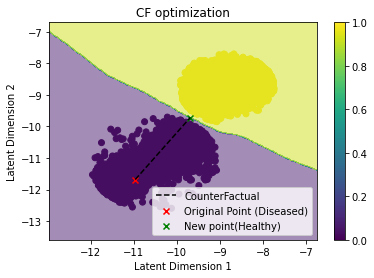

In [24]:
# Separate the dataset by class
class_0 = torch.where(mnist_subset_targets == 0)[0]

# Create a mask to filter out samples that are not in class 0
mask = (mnist_subset_targets != 0).squeeze()

# Select samples from latent space that are not in class 0
latent_space_not_0 = latent_vectors[mask]
latent_space_not_0 = latent_space_not_0[:,:2]

# Random point from class 0
random_index = torch.randint(high=class_0.shape[0], size=(1,))  # Choose a random index
class_0_random = latent_vectors[random_index]
class_0_random = class_0_random[:,:2].numpy()

# Train a 1-NN classifier on the dataset
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(latent_vectors, mnist_subset_targets.squeeze())

# Define a grid of points in the latent space
x_min, x_max = latent_vectors[:, 0].min() - 1, latent_vectors[:, 0].max() + 1
y_min, y_max = latent_vectors[:, 1].min() - 1, latent_vectors[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250), np.linspace(y_min, y_max, 250))
grid_latent_vectors = np.stack([xx.ravel(), yy.ravel()], axis=1)

# Make predictions with the classifier for the grid of points
Z = knn.predict(grid_latent_vectors).reshape(xx.shape)

# Compute the Euclidean distance between the original point and all points in the grid
distances = np.sqrt((grid_latent_vectors[:, 0] - class_0_random[0, 0])**2 + (grid_latent_vectors[:, 1] - class_0_random[0, 1])**2)

# Find the boundary points that have a different class label than the original point
mask_boundary = knn.predict(grid_latent_vectors) != knn.predict(class_0_random[0, :2].reshape(1, -1))
boundary_distances = np.where(mask_boundary, distances, np.inf)

# Find the point on the boundary with the shortest distance to the original point
min_distance_idx = np.argmin(boundary_distances)
x1, y1 = grid_latent_vectors[min_distance_idx]

# Plot the full latent vectors in 2 dimensions
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=mnist_subset_targets)
plt.colorbar()
plt.title('CF optimization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Plot the random point from class 0
plt.contourf(xx, yy, Z, alpha=0.5, linewidths=5)
plt.scatter(class_0_random[0,0], class_0_random[0,1], c='r', marker='x', label='Original Point (Diseased)')

# Plot the new point on the decision boundary
plt.scatter(x1, y1, c='g', marker='x', label='New point(Healthy)')

# Draw a line between the random point and the new point on the decision boundary
plt.plot([class_0_random[0,0], x1], [class_0_random[0,1], y1], c='k',linestyle='--', label='CounterFactual')

plt.legend()
plt.show()